In [ ]:
# Environment specified in environment.yml (environment name map_matching_particle_filter)
# conda env create --prefix ./envs -f environment.yml

In [1]:
import pandas as pd
import numpy as np
import os, sys
import glob, re, time

import shapely
from shapely.strtree import STRtree
from shapely.geometry import shape, Point, LineString, MultiLineString
from shapely.ops import nearest_points
import folium
import fiona
import pyproj
from functools import partial
import math

from collections import Counter

from sklearn.metrics.pairwise import haversine_distances  # Assumes (lat, long) in radians; version 0.22.1

In [2]:
os.getcwd()

'/Volumes/LaCie/Documents/repos/particle_filter'

In [ ]:
"""
Applications of particle filters: 
1. Car positioning by map matching, as in http://www.diva-portal.org/smash/get/diva2:316556/FULLTEXT01.pdf
    Essentially same approach is described in Davidson, Collin, and Takala (2011). Application of particle filters to map-matching algorithm
    Idea also similar to Newson and Krumm (2009), though HMM is used there.
    More recent resource: Murphy, Pao, Yuen (2019). Lyft; Map matching when the map is wrong: Efficient on/off road vehicle tracking and map learning

Ideas
Rao-Blackwellization (use Kalman filter for the linear part of the dynamics model)

Initial Approach:
Use Newson and Krumm, but modify it to use particle filters instead of HMM.

So, for a given route, proceed sequentially over obs, maintaining dist of probable road segments

Assumptions (N&K):
-remove obs that are not 2*meas dist sigma from previous obs  (eliminate 39% of data in N&K)
-ignore roads 200m from obs
-zeroize very unlikely particles
"""

In [3]:
def great_circle_dist(df):
    """
    USED BELOW IN PREPROCESSING
    df numpy array [lat, long, lat_prev, long_prev] in degrees
    
    Returns great-circle distance between point (lat,long) columns and (lat_prev, long_prev) columns, 
    in meters.
    
    Modified from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    df = df.copy()
    df = np.deg2rad(df)

    # haversine formula 
    dlon = df[:, 3] - df[:, 1] # lon2 - lon1 
    dlat = df[:, 2] - df[:, 0] # lat2 - lat1 
    a = np.add(np.square(np.sin(dlat / 2)),
               np.multiply(np.cos(df[:, 0]), 
                           np.multiply(np.cos(df[:, 2]), np.square(np.sin(dlon / 2)))
                          )
              )
    # a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = np.arcsin(np.sqrt(a)) * 2
    # c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return r * c * 1000

In [34]:
class gps_transition_model:
    """
    Transition model to predict probability of next state given current state; simulate next state.
    GPS trace map matching use case. 
    
    N&K use as a proxy an exponential function of the difference in the great-circle distance 
    between previous observations and previous road points (similar route distance).
    Road points use map/ground-truth data. 
    -Ignore roads 200m from obs
    -If a calculated route would require the vehicle to exceed a speed of 50 m/s (112 miles per hour), zeroize
    
    !!! TODO: Get driving distance from route planner??? Results anticipated to significantly suffer otherwise. !!! 
    
    Other ideas: using dead reckoning.
    """
    def __init__(self, beta=3.0
#                  , prob_floor=0.05
                 , normalize=True
                ):
        """
        beta, float, parametrizes transition probability function
        prob_floor, float between 0 and 1, is probability below which road choices are given zero probability
        
        # beta = 3 in mapzen, https://www.mapzen.com/blog/data-driven-map-matching/
        """
        self.beta = beta
#         self.prob_floor = min(max(prob_floor, 0), 1)
        self.normalize = normalize
    
    def estimate_beta(self, data):
        """
        NOT USED
        
        Using rescaled median absolute deviation (MAD). 
        Ideally using ground truth data (none here).
        """ 
        self.beta = 3.0  # None
        
    def prob_transition(self, state_last2, obs_last2, dist_obs_m_prev, time_delta_sec_prev, 
                        max_allowable_diff_m=2000.0, max_allowable_mph=112.0):
        """
        state_last2, float numpy array, (n * c x 4 lat, long, lat_prev, long_prev), c candidate roads and n particles
        obs_last2, float numpy array, (1 x 4 lat, long, lat_prev, long_prev) 
        dist_obs_m_prev float distance in meters between last two obs.
        time_delta_sec_prev float time delta in sec between last two obs.
        max_allowable_diff_m float, ignore low probability routes as in N&K; in N&K 2000 meters.
        max_allowable_mph, float; ignore routes resulting in unreasonable speeds. 112mph in N&K.
        Where present, lat/long in degrees.
        
        returns probs of transition, (n * c x 1)
        """
        RADIUS_OF_EARTH_M = 6371000
        MILES_PER_METER = 0.000621371
        HOURS_PER_SECOND = 3600.0
        state_last2 = np.deg2rad(state_last2)
        obs_last2 = np.deg2rad(obs_last2)
        # dist_obs = abs(haversine_distances(obs_last2[:, :2], obs_last2[0, 2:]))  # (1, 1)
        # !! TODO - Supposed to be driving distance, not haversine. N&K use a route planner. Can I use shapely???
            # Probably fine as generally GPS measurements are taken close together in time- 
            # Otherwise would have to snap to roads using Shapely and get the distance between the two points. 
            # How does using driving distance even compare to haversine for obs? Isn't it better to compare apples to apples?
        dist_road = \
        np.abs(np.array([haversine_distances(state_last2[r, :2].reshape(1,2), state_last2[r, 2:].reshape(1,2))[0] 
                         for r in range(state_last2.shape[0])]))  # (n * c, 1)
        dist_road = dist_road * RADIUS_OF_EARTH_M  # multiply by Earth radius to get result in meters
        diff_dist = np.abs(np.subtract(dist_road, dist_obs_m_prev))  # (n * c, 1)
        
        # Ignore cases where diff_dist >= max_allowable_diff_m
        diff_dist[diff_dist >= max_allowable_diff_m] = np.float("inf")  # zero out these transition probs
        # Ignore cases where implied speed of route is >= max_allowable_mph; calculate speed in candidate routes
        implied_speed_road = np.divide(dist_road * MILES_PER_METER, 
                               time_delta_sec_prev * HOURS_PER_SECOND)  # (n * c, 1), meters
        diff_dist[implied_speed_road >= max_allowable_mph] = np.float("inf")  # zero out these transition probs
        
        probs = np.exp(-diff_dist / self.beta) * (1 / self.beta)
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs

In [33]:
class gps_sensor_model:
    """
    Sensor model to predict likelihood of an obs given a particle.
    GPS trace map matching use case. 
    
    I don't have ground truth, so can't use ML easily, but
    N&K use as a proxy a normal distribution of great-circle distance between observation and road, with sigma 
    estimated from the data.
    Road points use map data. 
    -Zerioze low probability particles (diff in route distance of 2000 m. or more). 
    
    Other ideas: semi-supervised learning. 
    
    Thoughts: need efficient representation for road network that returns connecting roads/nodes for a given node
    Want to represent it as a graph/network. 
    """
    def __init__(self, sigma=4.07, normalize=True):
        self.sigma = sigma
        self.normalize = normalize
    
    def estimate_sigma(self, data):
        """
        NOT USED 
        
        Using Gather and Schultze, median-based. 
        Ideally using ground truth data (none here).
        
        I guess I could manually match some trips, then use that??
        """ 
        self.sigma = 4.07 # meters; I have no ground truth so using N&K's empirical estimate
#         self.sigma = None # median absolute deviation (MAD) formula adjusted 
    
    def estimate_likelihood(self, states, obs_coords):
        """
        return probability of seeing that obs given potential road state hypotheses, (k x 1)
        
        states Particles numpy array representing road position hypotheses, (k x 2 lat long).
        obs_coords (1 x 2 lat long)
        lat long in degrees
        """
        RADIUS_OF_EARTH_M = 6371000
        dist_obs_roads = np.abs(haversine_distances(np.deg2rad(states), np.deg2rad(obs_coords)))  # (k x 1)
        dist_obs_roads = dist_obs_roads * RADIUS_OF_EARTH_M  # multiply by Earth radius to get result in meters
        
        probs = \
        np.exp(np.power(dist_obs_roads / self.sigma, 2) * (-0.5)) * \
        (1 / (math.sqrt(2 * math.pi) * self.sigma))
        
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs

In [654]:
# BEGIN DEBUGGING
road_strtree; n=50; max_road_dist_m=200; prob_floor=0.0; 
sensor_model=gps_sensor_model(); transition_model=gps_transition_model(); 
viterbi_trellis=[]; viterbi_trellis_idx=[]

prob_floor = min(max(prob_floor, 0), 1)
particles = np.array([])
weights = np.ones((1, n))

fitted = False
        
obs_history = []

In [617]:
def get_candidate_roads(obs):
    """
    obs list of floats [lat, long]
    max_dist maximum allowable closest distance for prospective matched roads; those whose 
    closest point is >= max_dist meters away are ignored (200 in N&K).
    Returns numpy array float of lat,long closest point to road from obs (N&K).

    Leverages shapely and shapefiles for cabspotting data.
    Relies on great_circle_dist() helper function. 
    """
    # Fiona uses (long, lat) format
    obs = Point(obs[::-1])
    # Want to consider only matches within max_dist meters
    # Need to transform decimal degrees into meters
    # Should I deviate from the default value of buffer for a Point??
    # According to 200 * 360 / (2 * np.pi * 6371000), a distance of 200m corresponds to 0.0017986432118374611 decimal degrees
    # obs.buffer(1.0)
    matching_roads = road_strtree.query(obs.buffer(0.002))
    if len(matching_roads) == 0:
        matching_roads = road_strtree.query(obs.buffer(1.0))  # This should be a big buffer
    # If matching roads is still empty, return None
    if len(matching_roads) == 0:
        print("No matching roads found! Aborting particle filter.")
        return None
    # Ordered as (obs, road); just take road's coords
    # Take only the closest point on the candidate road (1st index)
    closest_pts = np.array([[list(p.coords)[0] for p in nearest_points(obs, r)][1] for r in matching_roads])
    # Calculate distance between obs and candidate_roads, to filter them
    candidate_dist_coords = \
    np.concatenate([closest_pts, np.tile(np.array(obs), (closest_pts.shape[0], 1))], axis=1)
    # Convert back to lat, long from long, lat
    candidate_dist_coords = candidate_dist_coords[:, [1, 0, 3, 2]]
    candidate_dists = great_circle_dist(candidate_dist_coords)
    # Filtered result of closest point on matching candidate roads
    # no. matches 2 (default buffer); 52 (buffer of 0.002); 74 (buffer of 1.0)
        # Reverse order to be lat, long
    candidate_roads = closest_pts[candidate_dists <= max_road_dist_m][:, [1,0]]
    return candidate_roads

In [302]:
def estimate_weights_per_particle(sampled_states, obs_coords):
    """
    Estimate likelihood of particle given evidence, P(evidence|particle).
    Uses sensor model.

    obs_coords is single observation at time t, pandas series. 
    """
    probs = sensor_model.estimate_likelihood(sampled_states, obs_coords.values.reshape(1, 2))
    return probs

In [508]:
# Crossproduct for each particle, all roads
state_last2 = np.concatenate([np.concatenate((particles, 
                                              np.tile(c, (n, 1))), 
                                             axis=1) 
                              for c in candidate_roads], axis=0)

In [393]:
state_last2.shape 

(2600, 4)

In [509]:
obs_last2 = np.array(obs_history[-2:]).reshape((1, 4))

In [481]:
obs_last2

array([[  37.75134, -122.39488,   37.75136, -122.39527]])

In [482]:
dist_obs_m_prev=dist_prev; time_delta_sec_prev=time_delta_prev; max_allowable_diff_m=2000.0; max_allowable_mph=112.0

In [403]:
dist_obs_m_prev

34.360479144304016

In [404]:
time_delta_sec_prev

-28.0

In [400]:
RADIUS_OF_EARTH_M = 6371000
MILES_PER_METER = 0.000621371
HOURS_PER_SECOND = 3600.0
state_last2 = np.deg2rad(state_last2)
obs_last2 = np.deg2rad(obs_last2)

In [435]:
state_last2

array([[ 0.65888492, -2.13619363,  0.65885333, -2.13619095],
       [ 0.65888522, -2.13619324,  0.65885333, -2.13619095],
       [ 0.65888522, -2.13619324,  0.65885333, -2.13619095],
       ...,
       [ 0.65888492, -2.13619363,  0.65891336, -2.13618996],
       [ 0.65888522, -2.13619324,  0.65891336, -2.13618996],
       [ 0.65888522, -2.13619324,  0.65891336, -2.13618996]])

In [439]:
dist_road = \
np.abs(np.array([haversine_distances(state_last2[r, :2].reshape(1,2), state_last2[r, 2:].reshape(1,2))[0] 
 for r in range(state_last2.shape[0])]))  # (n * c, 1)

In [440]:
dist_road = dist_road * RADIUS_OF_EARTH_M

In [442]:
diff_dist = np.abs(np.subtract(dist_road, dist_obs_m_prev))  # (n * c, 1)

In [443]:
diff_dist

array([[167.33782252],
       [169.1049927 ],
       [169.1049927 ],
       ...,
       [147.78968822],
       [145.7182921 ],
       [145.7182921 ]])

In [444]:
diff_dist.shape

(2600, 1)

In [452]:
np.min(diff_dist)

0.46792129264360227

In [448]:
# Ignore cases where diff_dist >= max_allowable_diff_m
diff_dist[diff_dist >= max_allowable_diff_m] = np.float("inf")  # zero out these transition probs

In [455]:
# Ignore cases where implied speed of route is >= max_allowable_mph; calculate speed in candidate routes
implied_speed_road = np.divide(dist_road * MILES_PER_METER, 
                               time_delta_sec_prev * HOURS_PER_SECOND)  # (n * c, 1), meters

In [458]:
diff_dist[implied_speed_road >= max_allowable_mph] = np.float("inf")  # zero out these transition probs

In [459]:
beta=3.0

In [472]:
probs = np.exp(-diff_dist / beta) * (1 / beta)

In [474]:
probs = probs / np.sum(probs)

In [703]:
def prob_transition(self, state_last2, obs_last2, dist_obs_m_prev, time_delta_sec_prev, 
                        max_allowable_diff_m=2000.0, max_allowable_mph=112.0):
        """
        state_last2, float numpy array, (n * c x 4 lat, long, lat_prev, long_prev), c candidate roads and n particles
        obs_last2, float numpy array, (1 x 4 lat, long, lat_prev, long_prev) 
        dist_obs_m_prev float distance in meters between last two obs.
        time_delta_sec_prev float time delta in sec between last two obs.
        max_allowable_diff_m float, ignore low probability routes as in N&K; in N&K 2000 meters.
        max_allowable_mph, float; ignore routes resulting in unreasonable speeds. 112mph in N&K.
        Where present, lat/long in degrees.
        
        returns probs of transition, (n * c x 1)
        """
        RADIUS_OF_EARTH_M = 6371000
        MILES_PER_METER = 0.000621371
        HOURS_PER_SECOND = 3600.0
        state_last2 = np.deg2rad(state_last2)
        obs_last2 = np.deg2rad(obs_last2)
        # dist_obs = abs(haversine_distances(obs_last2[:, :2], obs_last2[0, 2:]))  # (1, 1)
        # !! TODO - Supposed to be driving distance, not haversine. N&K use a route planner. Can I use shapely???
            # Probably fine as generally GPS measurements are taken close together in time- 
            # Otherwise would have to snap to roads using Shapely and get the distance between the two points. 
            # How does using driving distance even compare to haversine for obs? Isn't it better to compare apples to apples?
        dist_road = \
        np.abs(np.array([haversine_distances(state_last2[r, :2].reshape(1,2), state_last2[r, 2:].reshape(1,2))[0] 
                         for r in range(state_last2.shape[0])]))  # (n * c, 1)
        dist_road = dist_road * RADIUS_OF_EARTH_M  # multiply by Earth radius to get result in meters
        diff_dist = np.abs(np.subtract(dist_road, dist_obs_m_prev))  # (n * c, 1)
        
        # Ignore cases where diff_dist >= max_allowable_diff_m
        diff_dist[diff_dist >= max_allowable_diff_m] = np.float("inf")  # zero out these transition probs
        # Ignore cases where implied speed of route is >= max_allowable_mph; calculate speed in candidate routes
        implied_speed_road = np.divide(dist_road * MILES_PER_METER, 
                               time_delta_sec_prev * HOURS_PER_SECOND)  # (n * c, 1), meters
        diff_dist[implied_speed_road >= max_allowable_mph] = np.float("inf")  # zero out these transition probs
        
        probs = np.exp(-diff_dist / self.beta) * (1 / self.beta)
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)

In [510]:
probs = transition_model.prob_transition(state_last2, obs_last2, 
                                         dist_prev, time_delta_prev)  # (n * c, 1)

In [511]:
sorted(probs)[-5:]

[array([0.00898015]),
 array([0.00898015]),
 array([0.00898015]),
 array([0.00898015]),
 array([0.00898015])]

In [512]:
prob_floor

0.0

In [513]:
np.sum(probs <= prob_floor)

0

In [514]:
probs[probs <= prob_floor] = 0.0

In [515]:
probs = probs / np.sum(probs)

In [516]:
sorted(probs)[-5:]

[array([0.00898015]),
 array([0.00898015]),
 array([0.00898015]),
 array([0.00898015]),
 array([0.00898015])]

In [710]:
state_last2 = np.concatenate([np.concatenate((particles, 
                                                  np.tile(c, (n, 1))), 
                                                 axis=1) 
                                  for c in candidate_roads], axis=0)

In [715]:
state_last2

array([[  37.75134205, -122.39485713,   37.7497545 , -122.3962862 ],
       [  37.75134205, -122.39485713,   37.7497545 , -122.3962862 ],
       [  37.75132504, -122.39487933,   37.7497545 , -122.3962862 ],
       ...,
       [  37.75132504, -122.39487933,   37.7529547 , -122.3946691 ],
       [  37.75134205, -122.39485713,   37.7529547 , -122.3946691 ],
       [  37.75132504, -122.39487933,   37.7529547 , -122.3946691 ]])

In [712]:
obs_last2 = np.array(obs_history[-2:]).reshape((1, 4))

In [713]:
obs_last2

array([[  37.75134, -122.39488,   37.75136, -122.39527]])

In [716]:
probs = transition_model.prob_transition(state_last2, obs_last2, 
                                             dist_prev, time_delta_prev)

In [719]:
probs

array([[4.17545221e-29],
       [4.17545221e-29],
       [1.01753694e-28],
       ...,
       [4.15709313e-24],
       [8.29191906e-24],
       [4.15709313e-24]])

In [720]:
prob_floor

0.01

In [ ]:
probs[probs <= prob_floor] = 0.0

In [707]:
def apply_transition_model(candidate_roads, dist_prev, time_delta_prev):
    """
    returns probabilities of transition, given current particles
    numpy array of floats between 0 and 1, normalized, (n * c, 1)

    candidate_roads numpy array float of lat,long closest point to road from obs (N&K)
    dist_prev float, meters
    time_delta_prev float, sec

    Zeroize very small probability candidates, but don't change shape of particles.
    Then, if some particles are very unlikely, we cull them and resample from more likely particles. 
    """
    # Crossproduct for each particle, all roads
    state_last2 = np.concatenate([np.concatenate((particles, 
                                                  np.tile(c, (n, 1))), 
                                                 axis=1) 
                                  for c in candidate_roads], axis=0)  # (n * c, 4)
    obs_last2 = np.array(obs_history[-2:]).reshape((1, 4))
    probs = transition_model.prob_transition(state_last2, obs_last2, 
                                             dist_prev, time_delta_prev)  # (n * c, 1)
    # Effectively, candidate roads will be possible from different original particle hypotheses
    # Zeroise small probs, without changing array shape
    probs[probs <= prob_floor] = 0.0
    # Re-normalize
    probs = probs / np.sum(probs)
    return probs

In [691]:
obs

lat                  37.751360
long               -122.395270
lat_prev             37.751340
long_prev          -122.394880
dist_from_prev_m     34.360479
time_delta_sec      -28.000000
Name: 1, dtype: float64

In [695]:
obs_coords = obs[['lat', 'long']] # obs[:2]
dist_prev, time_delta_prev = obs[['dist_from_prev_m', 'time_delta_sec']] # obs[2:]

In [696]:
time_delta_prev

-28.0

In [676]:
obs_history.append(obs_coords)

In [697]:
obs_history

[lat      37.75134
 long   -122.39488
 Name: 0, dtype: float64,
 lat      37.75136
 long   -122.39527
 Name: 1, dtype: float64]

In [698]:
candidate_roads = get_candidate_roads(obs_coords)

In [699]:
candidate_roads

array([[  37.7497545 , -122.3962862 ],
       [  37.7497851 , -122.3957776 ],
       [  37.74982094, -122.39517989],
       [  37.7498409 , -122.3948389 ],
       [  37.749877  , -122.3942223 ],
       [  37.7499376 , -122.3965082 ],
       [  37.749877  , -122.3942223 ],
       [  37.7500518 , -122.3946562 ],
       [  37.7501218 , -122.3965221 ],
       [  37.7500518 , -122.3946562 ],
       [  37.7501218 , -122.3965221 ],
       [  37.7504893 , -122.3966962 ],
       [  37.750809  , -122.395448  ],
       [  37.7508977 , -122.3934267 ],
       [  37.7505055 , -122.3963543 ],
       [  37.7510282 , -122.3947529 ],
       [  37.7505509 , -122.3947056 ],
       [  37.7507095 , -122.3966147 ],
       [  37.7506223 , -122.3935102 ],
       [  37.7507267 , -122.394723  ],
       [  37.7512915 , -122.3952268 ],
       [  37.7508102 , -122.3935227 ],
       [  37.7509976 , -122.3963989 ],
       [  37.7508768 , -122.3962566 ],
       [  37.75092   , -122.3956145 ],
       [  37.75126053, -1

In [680]:
num_iter

2

In [722]:
trans_probs = apply_transition_model(candidate_roads, 
                                      dist_prev, 
                                      time_delta_prev) # (n * c, 1) first n rows for first candidate, etc.

In [723]:
trans_probs

array([[4.17545221e-29],
       [4.17545221e-29],
       [1.01753694e-28],
       ...,
       [4.15709313e-24],
       [8.29191906e-24],
       [4.15709313e-24]])

In [724]:
# Aggregate probs by candidate roads
trans_probs_split = np.array(np.split(trans_probs, n, axis=0))  # (n, c, 1)

In [725]:
trans_probs_split.shape

(50, 50, 1)

In [726]:
np.sum(np.array(trans_probs_split), axis=0).shape

(50, 1)

In [727]:
trans_probs_agg = np.sum(trans_probs_split, axis=0)  # (c, 1)

In [728]:
sorted(trans_probs_agg)[-10:]

[array([0.02126911]),
 array([0.02126911]),
 array([0.02126911]),
 array([0.02126911]),
 array([0.02126911]),
 array([0.02126911]),
 array([0.02126911]),
 array([0.02126911]),
 array([0.02126911]),
 array([0.02126911])]

In [729]:
trans_probs_agg.shape

(50, 1)

In [731]:
trans_probs_agg.flatten()

array([0.01882851, 0.01882851, 0.02126911, 0.02126911, 0.01882851,
       0.02126911, 0.01882851, 0.02126911, 0.01882851, 0.02126911,
       0.02126911, 0.01882851, 0.01882851, 0.02126911, 0.02126911,
       0.02126911, 0.01882851, 0.02126911, 0.02126911, 0.01882851,
       0.01882851, 0.01882851, 0.01882851, 0.01882851, 0.01882851,
       0.02126911, 0.02126911, 0.02126911, 0.02126911, 0.01882851,
       0.02126911, 0.01882851, 0.01882851, 0.02126911, 0.01882851,
       0.01882851, 0.01882851, 0.01882851, 0.01882851, 0.01882851,
       0.02126911, 0.02126911, 0.02126911, 0.02126911, 0.01882851,
       0.02126911, 0.01882851, 0.02126911, 0.01882851, 0.02126911])

In [732]:
# Sample new states
sampled_states_idx = np.random.choice(range(len(candidate_roads)), 
                                      n, 
                                      list(trans_probs_agg.flatten()))  # (n, )

In [733]:
sampled_states_idx.shape

(50,)

In [660]:
# sampled_states = candidate_roads

In [734]:
sampled_states = candidate_roads[sampled_states_idx]  # (n, 2)

In [735]:
sampled_states.shape

(50, 2)

In [362]:
# sampled_states = candidate_roads

In [736]:
%%time
sensor_probs = estimate_weights_per_particle(sampled_states, obs_coords)

CPU times: user 168 µs, sys: 31 µs, total: 199 µs
Wall time: 205 µs


In [737]:
sensor_probs.shape

(50, 1)

In [738]:
sensor_probs[sensor_probs > 0.01]

array([0.24459976, 0.75539978])

In [739]:
trans_probs_split.shape

(50, 50, 1)

In [740]:
np.max(trans_probs_split, axis=0)[sampled_states_idx].shape

(50, 1)

In [741]:
sensor_probs.shape

(50, 1)

In [742]:
weights.shape

(50, 1)

In [667]:
# joint_prob = sensor_probs[new_particles_idx]

In [743]:
# joint_prob = sensor_probs
joint_prob = np.multiply(
        np.multiply(sensor_probs, np.max(trans_probs_split, axis=0)[sampled_states_idx]),  # (n, 1)
        weights
        )

In [744]:
joint_prob.shape

(50, 1)

In [748]:
weights = joint_prob

In [ ]:
test=pd.DataFrame(np.array([[1,3],[1,2], [1,6], [2,5], [2,5],[2,3]]))

In [75]:
test

,0,1
0,1,3
1,1,2
2,1,6
3,2,5
4,2,5
5,2,3


In [135]:
sampled_states_idx=np.array([2, 1]); new_particles_idx=np.array([0, 0])

In [136]:
[sampled_states_idx[new_particles_idx]]

[array([2, 2])]

In [137]:
np.array([(np.array([sampled_states_idx[new_particles_idx]]) + 3 * (i-1)) for i in range(1, 3)]).flatten()

array([2, 2, 5, 5])

In [138]:
test.loc[np.array([(np.array([sampled_states_idx[new_particles_idx]]) + 3 * (i-1)) for i in range(1, 3)]).flatten(), :]

,0,1
2,1,6
2,1,6
5,2,3
5,2,3


In [ ]:
# Use trans_probs!!! (n * c, 1)

In [139]:
best_prior_state_idx = \
pd.DataFrame(test).loc[np.array([(np.array([sampled_states_idx[new_particles_idx]]) + 3 * (i-1)) 
                                        for i in range(1, 3)]).flatten(), :
                             ].groupby([0])[1].idxmax().values.reshape(1,-1)

In [178]:
best_prior_state_idx % 3

array([[2, 2]])

In [179]:
test.values[best_prior_state_idx][0]

array([[1, 6],
       [2, 3]])

In [121]:
best_prior_state_idx = \
pd.DataFrame(trans_probs).loc[np.array([(np.array([sampled_states_idx[new_particles_idx]]) + 
                                         len(candidate_roads) * (i - 1)) 
                                        for i in range(1, (self.n + 1))]).flatten(), :
                             ].groupby([0])[1].idxmax().values.reshape(1, -1)

NameError: name 'trans_probs' is not defined

In [872]:
best_prior_state_idx.shape

(1, 50)

In [873]:
best_prior_state_idx

array([[0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0,
        0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        0, 2, 0, 2, 0, 2]])

In [773]:
best_prior_state = particles[best_prior_state_idx][0]  # (n, 2)

In [774]:
best_prior_state.shape

(50, 2)

In [780]:
viterbi_trellis.append(best_prior_state)

In [781]:
viterbi_trellis_idx.append(best_prior_state_idx)

In [664]:
# Sample new particles
new_particles_idx = np.random.choice(a=range(sampled_states.shape[0]), 
                                     size=n, 
                                     p=sensor_probs.flatten())  # (1, n)

In [666]:
new_particles = sampled_states[new_particles_idx]  # (n, 2)

In [749]:
particles = new_particles

In [750]:
# Estimate current particle filter fit quality of hypotheses to data; should research good metrics more.
    # Came up with this on my own. 
fit_quality = [np.max(weights), np.mean(weights), np.median(weights)]

In [751]:
fit_quality

[0.0032343141665107955, 8.015634433554048e-05, 2.8602818874616793e-174]

In [ ]:
# def update_dist(obs, num_iter, max_dist2=None):
"""
Re-sample particles from transition model given re-estimated likelihood of existing particles.
Weighted sample with replacement. 

numpy array of floats [lat, long, dist_from_prev_m, time_delta_sec]

Note: if find no solutions, need to remove points in a signal break until HMM 'heals.'
If break > 180 sec, separate into two trips.
"""
# Update stored obs
obs_coords = obs[['lat', 'long']] # obs[:2]
dist_prev, time_delta_prev = obs[['dist_from_prev_m', 'time_delta_sec']] # obs[2:]
obs_history.append(obs_coords)
# Get candidate roads given obs
candidate_roads = get_candidate_roads(obs_coords) # ignore distance
# What if candidate_roads is empty?? Then, seems logical to return No Match, and abort. 
if candidate_roads is None:
    return 'Aborted'
# Get transition probs; for first observation, ignore this part of the algorithm 
# and treat sensor probs as prior probabilities (N&K.
if num_iter > 1:
    trans_probs = apply_transition_model(candidate_roads, 
                                              dist_prev, 
                                              time_delta_prev) # (n * c, 1) first n rows for first candidate, etc.
    # Aggregate probs by candidate roads
    trans_probs_split = np.array(np.split(trans_probs, n, axis=0))  # (n, c, 1)
    trans_probs_agg = np.sum(trans_probs_split, axis=0)  # (c, 1)
    # Sample new states
    # Sample new states
    sampled_states_idx = np.random.choice(range(len(candidate_roads)), 
                                      n, 
                                      list(trans_probs_agg.flatten()))  # (n, )
    sampled_states = candidate_roads[sampled_states_idx]  # (n, 2)
else:
    sampled_states = candidate_roads

# Get sensor probs
sensor_probs = estimate_weights_per_particle(sampled_states, obs_coords)  # (n, 1)

# Joint prob, for viterbi backtracking. 
if num_iter > 1:
    joint_prob = np.multiply(
        np.multiply(sensor_probs, np.max(trans_probs_split, axis=0)[sampled_states_idx]),  # (n, 1)
        weights
        )
# else:
#     joint_prob = sensor_probs
# weights = joint_prob  # Effectively setting prior probabilites in iter 1

# Sample new particles
new_particles_idx = np.random.choice(a=range(sampled_states.shape[0]), 
                                     size=n, 
                                     p=sensor_probs.flatten())  # (1, n) if not iter 1 else (1, c) 
new_particles = sampled_states[new_particles_idx]  # (n, 2)

# Best prior state/particle for a given candidate state, for viterbi backtracking. 
if num_iter > 1:
    best_prior_state_idx = \
    pd.DataFrame(trans_probs).loc[np.array([(np.array([sampled_states_idx[new_particles_idx]]) + 
                                         len(candidate_roads) * (i - 1)) 
                                        for i in range(1, (n + 1))]).flatten(), :
                             ].groupby([0])[1].idxmax().values.reshape(1, -1) # (1, n)
    best_prior_state_idx = best_prior_state_idx % len(candidate_roads)  # get back to particle-space
    best_prior_state = particles[best_prior_state_idx][0]  # (n, 2)
    viterbi_trellis.append(best_prior_state)
    viterbi_trellis_idx.append(best_prior_state_idx)
else:
    joint_prob = sensor_probs[new_particles_idx]  # Effectively setting prior probabilites in iter 1
    
weights = joint_prob

particles = new_particles

# Estimate current particle filter fit quality of hypotheses to data; should research good metrics more.
    # Came up with this on my own. 
fit_quality = [np.max(weights), np.mean(weights), np.median(weights)]

return fit_quality

In [646]:
num_iter = 0
converged = False

In [647]:
data.head()

,lat,long,lat_prev,long_prev,dist_from_prev_m,time_delta_sec
0,37.75134,-122.39488,NaN,NaN,NaN,NaN
1,37.75136,-122.39527,37.75134,-122.39488,34.360479,-28.0
2,37.75199,-122.39460,37.75136,-122.39527,91.527346,-119.0
3,37.75080,-122.39346,37.75199,-122.39460,165.996049,-51.0
4,37.75015,-122.39256,37.75080,-122.39346,107.168918,-252.0


In [673]:
obs = data.iloc[1, :]

In [368]:
obs

lat                  37.751360
long               -122.395270
lat_prev             37.751340
long_prev          -122.394880
dist_from_prev_m     34.360479
time_delta_sec      -28.000000
Name: 1, dtype: float64

In [674]:
num_iter += 1

In [ ]:
# def fit(data#, max_iter=100, conv_tol=0.001
#            ):
"""
Iterate over rows in data, training particle filter. 
Rows assumed to be sequentially ordered. 

data, numpy array (num obs, data dim)
data cols include lat, long, dist_from_prev_m, time_delta_sec (all floats)

Note, calling fit multiple times would result in nonsense results, so this is prevented. 
"""
if fitted:
    print("Already fit - Cannot fit multiple times.")
    return None
data = data.copy()
num_iter = 0
converged = False  # Is this relevant for particle filters?
#         while num_iter < max_iter and not converged:
#             num_iter += 1
for obs in data:
    num_iter += 1
    fit_quality = update_dist(obs, num_iter)
    if fit_quality == "Aborted":
        return "Aborted"
    # Shouldn't I use DP/Viterbi for this?? 
    # Nearest neighbor filter, hungarian algorithm?? p. 601
    # Best at any given point in time will suffer in the beginning before particle dist has converged, ie
    # during the burn-in period.
    # So, seems can still use DP, but proceed backward in time. Wait, that is Viterbi :) 
        # Happily I have a finite state space. 
    print("On iteration %d, fit quality of MAX %3.2f, MEAN %3.2f, MEDIAN %3.2f" % 
          (num_iter, fit_quality[0], fit_quality[1], fit_quality[2]))
print("Done.")
fitted = True
return fit_quality

In [783]:
best_last_state_idx = np.argmax(weights)

In [784]:
best_last_state_idx

35

In [785]:
best_last_state = particles[best_last_state_idx]

In [786]:
best_last_state

array([  37.75134205, -122.39485713])

In [787]:
backtracked_states = [best_last_state]

In [788]:
backtracked_states

[array([  37.75134205, -122.39485713])]

In [790]:
j=len(viterbi_trellis) - 1

In [791]:
j

1

In [800]:
viterbi_trellis_idx[j].shape

(1, 50)

In [805]:
best_last_state_idx = viterbi_trellis_idx[j].flatten()[best_last_state_idx]

In [806]:
best_last_state_idx

0

In [807]:
best_last_state = viterbi_trellis[j][best_last_state_idx]

In [808]:
best_last_state

array([  37.75134205, -122.39485713])

In [809]:
backtracked_states.append(best_last_state)

In [810]:
backtracked_states

[array([  37.75134205, -122.39485713]), array([  37.75134205, -122.39485713])]

In [811]:
for j in range(len(viterbi_trellis) - 1, -1, -1):
    best_last_state_idx = viterbi_trellis_idx[j].flatten()[best_last_state_idx]
    best_last_state = viterbi_trellis[j][best_last_state_idx]
    backtracked_states.append(best_last_state)

In [812]:
# Put in chronological order
backtracked_states = backtracked_states[::-1]

In [814]:
backtracked_states

[array([  37.75134205, -122.39485713]),
 array([  37.75134205, -122.39485713]),
 array([  37.75134205, -122.39485713]),
 array([  37.75134205, -122.39485713])]

In [839]:
def viterbi():
    """
    Returns list of backtracked states (float lat long),
    the imputed GPS trace that has been 'snapped' to roads.
    Use Viterbi to get optimal path via DP - 
    happily I have a finite state space due to my constraint 
    to only maintain n particles. 

    Note1, Viterbi relies on the Markov property, which
    can apply here. 
    Note2, if particle filter was aborted due to no matching candidate roads,
    Viterbi will still be able to backtrack the trace up until that point. 
    """
    # Start with the last observation to the viterbi trellis
    best_last_state_idx = np.argmax(weights)
    best_last_state = particles[best_last_state_idx]
    backtracked_states = [best_last_state]
    # Backtrack through the viterbi trellis (#obs, n, 2) actual lat/long states
    for j in range(len(viterbi_trellis) - 1, -1, -1):
        best_last_state_idx = viterbi_trellis_idx[j].flatten()[best_last_state_idx]
        best_last_state = viterbi_trellis[j][best_last_state_idx]
        backtracked_states.append(best_last_state)
    # Put in chronological order
    backtracked_states = backtracked_states[::-1]
    return backtracked_states

In [ ]:
# END DEBUGGING

In [159]:
np.array(range(5*3))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [187]:
np.array([i for i in range(5)] * 3)

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

In [161]:
np.array([j for l in [[i]*3 for i in range(0,5)] for j in l])

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])

In [175]:
np.concatenate((np.array([j for l in [[i]*3 for i in range(0,5)] for j in l]).reshape(15,1),
                np.array(range(5*3)).reshape(15,1)
               ), axis=1
              )

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 3,  9],
       [ 3, 10],
       [ 3, 11],
       [ 4, 12],
       [ 4, 13],
       [ 4, 14]])

In [240]:
class particle_filter:
    """
    Fit a particle filter to data given a transition and sensor model. 
    
    n, integer, number of particles to maintain at each step in time.
    max_road_dist_m, float, max road distance above which candidate roads aren't considered (meters). 
    prob_floor, float between 0 and 1, min probability below which candidate roads aren't considered (not in N&K).
    Sensor model, , is some model object we will use to predict the likelihood.
    Transition model, , is some model object we will use to predict next state.
    ## max_iter, integer, the maximum iterations used in fitting the particle filter.
    ## conv_tol, the convergence tolerance that will trigger early termination of fitting the particle filter. 
    """
    def __init__(self, road_strtree, n=50, max_road_dist_m=200, prob_floor=0.0, 
                 sensor_model=gps_sensor_model(), transition_model=gps_transition_model(), 
                 viterbi_trellis=[], viterbi_trellis_idx=[]):
        self.road_strtree = road_strtree
        self.n = n
        self.max_road_dist_m = max_road_dist_m
        self.prob_floor = min(max(prob_floor, 0), 1)
        self.particles = np.array([])
        self.weights = np.zeros((1, self.n))  # Log-transform probabilities
        
        self.sensor_model = sensor_model
        self.transition_model = transition_model
        self.viterbi_trellis = viterbi_trellis
        self.viterbi_trellis_idx = viterbi_trellis_idx
        
        self.fitted = False
        
        self.obs_history = []  # Record history of observations (lat, long)
        
    def get_candidate_roads(self, obs):
        """
        obs list of floats [lat, long]
        max_dist maximum allowable closest distance for prospective matched roads; those whose 
        closest point is >= max_dist meters away are ignored (200 in N&K).
        Returns numpy array float of lat,long closest point to road from obs (N&K).

        Leverages shapely and shapefiles for cabspotting data.
        Relies on great_circle_dist() helper function. 
        """
        # Fiona uses (long, lat) format
        obs = Point(obs[::-1])
        # Want to consider only matches within max_dist meters
        # Need to transform decimal degrees into meters
        # Should I deviate from the default value of buffer for a Point??
        # According to 200 * 360 / (2 * np.pi * 6371000), a distance of 200m corresponds to 0.0017986432118374611 decimal degrees
        # obs.buffer(1.0)
        matching_roads = self.road_strtree.query(obs.buffer(0.002))
        if len(matching_roads) == 0:
            matching_roads = self.road_strtree.query(obs.buffer(1.0))  # This should be a big buffer
        # If matching roads is still empty, return None
        if len(matching_roads) == 0:
            print("No matching roads found! Aborting particle filter.")
            return None
        # Ordered as (obs, road); just take road's coords
        # Take only the closest point on the candidate road (1st index)
        closest_pts = np.array([[list(p.coords)[0] for p in nearest_points(obs, r)][1] for r in matching_roads])
        # Calculate distance between obs and candidate_roads, to filter them
        candidate_dist_coords = \
        np.concatenate([closest_pts, np.tile(np.array(obs), (closest_pts.shape[0], 1))], axis=1)
        # Convert back to lat, long from long, lat
        candidate_dist_coords = candidate_dist_coords[:, [1, 0, 3, 2]]
        candidate_dists = great_circle_dist(candidate_dist_coords)
        # Filtered result of closest point on matching candidate roads
        # no. matches 2 (default buffer); 52 (buffer of 0.002); 74 (buffer of 1.0)
            # Reverse order to be lat, long
        candidate_roads = closest_pts[candidate_dists <= self.max_road_dist_m][:, [1,0]]
        return candidate_roads
    
    def estimate_weights_per_particle(self, sampled_states, obs_coords):
        """
        Estimate likelihood of particle given evidence, P(evidence|particle).
        Uses sensor model.
        
        obs_coords is single observation at time t, pandas series. 
        """
        probs = self.sensor_model.estimate_likelihood(sampled_states, obs_coords.values.reshape(1, 2))
        return probs
        
    def apply_transition_model(self, candidate_roads, dist_prev, time_delta_prev):
        """
        returns probabilities of transition, given current particles
        numpy array of floats between 0 and 1, normalized, (n * c, 1)
        
        candidate_roads numpy array float of lat,long closest point to road from obs (N&K)
        dist_prev float, meters
        time_delta_prev float, sec
        
        Zeroize very small probability candidates, but don't change shape of particles.
        Then, if some particles are very unlikely, we cull them and resample from more likely particles. 
        """
        # Crossproduct for each particle, all roads
        state_last2 = np.concatenate([np.concatenate((self.particles, 
                                                      np.tile(c, (self.n, 1))), 
                                                     axis=1) 
                                      for c in candidate_roads], axis=0)  # (n * c, 4)
        obs_last2 = np.array(self.obs_history[-2:]).reshape((1, 4))
        probs = self.transition_model.prob_transition(state_last2, obs_last2, 
                                                      dist_prev, time_delta_prev)  # (n * c, 1)
        # Effectively, candidate roads will be possible from different original particle hypotheses
        # Zeroise small probs, without changing array shape
        probs[probs <= self.prob_floor] = 0.0
        # Re-normalize
        probs = probs / np.sum(probs)
        return probs
        
    def update_dist(self, obs, num_iter, max_dist2=None):
        """
        Re-sample particles from transition model given re-estimated likelihood of existing particles.
        Weighted sample with replacement. 
        
        obs numpy array of floats [lat, long, dist_from_prev_m, time_delta_sec]
        num_iter integer, iteration count
        max_dist2 not used

        Note: if find no solutions, need to remove points in a signal break until HMM 'heals.'
        If break > 180 sec, separate into two trips.
        """
        # Update stored obs
        obs_coords = obs[['lat', 'long']] # obs[:2]
        dist_prev, time_delta_prev = obs[['dist_from_prev_m', 'time_delta_sec']] # obs[2:]
        self.obs_history.append(obs_coords)
        # Get candidate roads given obs
        candidate_roads = self.get_candidate_roads(obs_coords) # ignore distance
        # What if candidate_roads is empty?? Then, seems logical to return No Match, and abort. 
        if candidate_roads is None:
            return 'Aborted'
        # Get transition probs; for first observation, ignore this part of the algorithm 
        # and treat sensor probs as prior probabilities (N&K.
        if num_iter > 1:
            trans_probs = self.apply_transition_model(candidate_roads, 
                                                      dist_prev, 
                                                      time_delta_prev) # (n * c, 1) first n rows for first candidate, etc.
            # Aggregate probs by candidate roads
            trans_probs_split = np.array(np.split(trans_probs, self.n, axis=0))  # (n, c, 1)
            trans_probs_agg = np.sum(trans_probs_split, axis=0)  # (c, 1)
            # Sample new states
            # Sample new states; index into candidate roads
            sampled_states_idx = np.random.choice(range(len(candidate_roads)), 
                                                  self.n, 
                                                  list(trans_probs_agg.flatten()))  # (n, )
            sampled_states = candidate_roads[sampled_states_idx]  # (n, 2)
        else:
            sampled_states = candidate_roads
        
        # Get sensor probs
        sensor_probs = self.estimate_weights_per_particle(sampled_states, obs_coords)  # (n, 1) 
        
        # Joint prob, for viterbi backtracking. Do this in the log domain.  
        if num_iter > 1:
            # May want to do this in the log domain?
            joint_prob = np.add(
                np.add(np.log(sensor_probs), np.max(np.log(trans_probs_split), axis=0)[sampled_states_idx]),  # (n, 1)
                self.weights
                )
#         else:
#             joint_prob = sensor_probs
#         self.weights = joint_prob  # Effectively setting prior probabilites in iter 1
        
        # Sample new particles, from the n sampled states
        new_particles_idx = np.random.choice(a=range(sampled_states.shape[0]), 
                                             size=self.n, 
                                             p=sensor_probs.flatten())  # (1, n) if not iter 1 else (1, c)
        new_particles = sampled_states[new_particles_idx]  # (n, 2)
        
        # Best prior state/particle for a given candidate state, for viterbi backtracking. 
        if num_iter > 1:
            # Tie together candidate road indices, particle indices, trans probs, and particles
            trans_probs_stack = \
            np.concatenate((np.array([[i] * self.n for i in range(len(candidate_roads))]
                                    ).reshape(len(candidate_roads) * self.n, 1), 
                            np.array([j for j in range(self.n)] * len(candidate_roads)
                                    ).reshape(len(candidate_roads) * self.n, 1), 
                            trans_probs.reshape(len(candidate_roads) * self.n, 1),
                            np.tile(self.particles, len(candidate_roads)).reshape(len(candidate_roads) * self.n, -1)
                           ), axis=1)  # (n * c, 5)   cols: particle_id and transition probs
            # For each candidate road, max-prob prev state.
            # Given candidate roads are sampled...
            trans_prob_idx = \
            np.array([(np.array([sampled_states_idx[new_particles_idx]]) + 
                                         len(candidate_roads) * (i - 1)) 
                                        for i in range(1, (self.n + 1))]).flatten()  # (n * c, 1)
            # ...of sampled roads, which prior states are most likely?
                # Not all roads may have been sampled.
                # idxmax is in the range <= c.
                # best_prior_state_idx is filtered particle indices
            best_prior_state_idx = \
            pd.DataFrame(trans_probs_stack).loc[trans_prob_idx, :
                             ].groupby([0])[2].idxmax().values.reshape(1, -1)  # (1, <= c)
            # get back to particle-space
            best_prior_state = trans_probs_stack[best_prior_state_idx][0][:, -2:]  # (<= c, 2)
            best_prior_state_idx = trans_probs_stack[best_prior_state_idx][0][:, 1]  # (<= c, 1)
#             best_prior_state_idx = math.floor(best_prior_state_idx / len(candidate_roads))
#             best_prior_state = self.particles[best_prior_state_idx][0]  # (n, 2)
            self.viterbi_trellis.append(best_prior_state)
            self.viterbi_trellis_idx.append(best_prior_state_idx)
        else:
            joint_prob = np.log(sensor_probs[new_particles_idx])  # Effectively setting prior probabilites in iter 1
            
        self.weights = joint_prob
        
        self.particles = new_particles
        
        # Estimate current particle filter fit quality of hypotheses to data; should research good metrics more.
            # Came up with this on my own. 
        fit_quality = [np.max(self.weights), np.mean(self.weights), np.median(self.weights)]
        
        return fit_quality
        
    def fit(self, data#, max_iter=100, conv_tol=0.001
           ):
        """
        Iterate over rows in data, training particle filter. 
        Rows assumed to be sequentially ordered. 
        
        data, numpy array: cols include lat, long, dist_from_prev_m, time_delta_sec (all floats).
        lat, long in decimal degrees.
        
        Returns fit_quality, list of floats: max, mean, and median probability of most recent particles.
        
        Note, calling fit multiple times would result in nonsense results, so this is prevented. 
        """
        if self.fitted:
            print("Already fit - Cannot fit multiple times.")
            return None
        data = data.copy()
        num_iter = 0
        converged = False  # Is this relevant for particle filters?
#         while num_iter < max_iter and not converged:
#             num_iter += 1
        for obs in data.iterrows():
            num_iter += 1
            fit_quality = self.update_dist(obs[1], num_iter)
            if fit_quality == "Aborted":
                return "Aborted"
            # Shouldn't I use DP/Viterbi for this?? 
            # Nearest neighbor filter, hungarian algorithm?? p. 601
            # Best at any given point in time will suffer in the beginning before particle dist has converged, ie
            # during the burn-in period.
            # So, seems can still use DP, but proceed backward in time. Wait, that is Viterbi :) 
                # Happily I have a finite state space. 
            print("On iteration %d, fit quality of MAX %3.2f, MEAN %3.2f, MEDIAN %3.2f" % 
                  (num_iter, fit_quality[0], fit_quality[1], fit_quality[2]))
        print("Done.")
        self.fitted = True
        return fit_quality
    
    def viterbi(self):
        """
        Returns list of backtracked states (float lat long),
        the imputed GPS trace that has been 'snapped' to roads.
        Use Viterbi to get optimal path via DP - 
        happily I have a finite state space due to my constraint 
        to only maintain n particles. 
        
        Note1, Viterbi relies on the Markov property, which
        can apply here. 
        Note2, if particle filter was aborted due to no matching candidate roads,
        Viterbi will still be able to backtrack the trace up until that point. 
        """
        # Start with the last observation to the viterbi trellis
        best_last_state_idx = np.argmax(self.weights)
        best_last_state = self.particles[best_last_state_idx]
        backtracked_states = [best_last_state]
        # Backtrack through the viterbi trellis (#obs, n, 2) actual lat/long states
        for j in range(len(self.viterbi_trellis) - 1, -1, -1):
            best_last_state_idx = self.viterbi_trellis_idx[j].flatten()[best_last_state_idx]
            best_last_state = self.viterbi_trellis[j][best_last_state_idx]
            backtracked_states.append(best_last_state)
        # Put in chronological order
        backtracked_states = backtracked_states[::-1]
        return backtracked_states

In [226]:
n=5; candidate_roads=np.array([1,2,3]); particles=np.array([1,2,3,4,5]); trans_probs = np.array(range(15))

In [228]:
np.array([[i] * n for i in range(len(candidate_roads))]
                                    ).reshape(len(candidate_roads) * n, 1).shape

(15, 1)

In [229]:
np.array([j for j in range(n)] * len(candidate_roads)).flatten().shape

(15,)

In [230]:
trans_probs.shape

(15,)

In [231]:
np.tile(particles, len(candidate_roads)).reshape(len(candidate_roads) * n, -1).shape

(15, 1)

In [234]:
trans_probs_stack = \
            np.concatenate((np.array([[i] * n for i in range(len(candidate_roads))]
                                    ).reshape(len(candidate_roads) * n, 1), 
                            np.array([j for j in range(n)] * len(candidate_roads)).reshape(len(candidate_roads) * n, 1), 
                            trans_probs.reshape(len(candidate_roads) * n, 1),
                            np.tile(particles, len(candidate_roads)).reshape(len(candidate_roads) * n, -1)
                           ), axis=1)

In [235]:
trans_probs_stack.shape

(15, 4)

In [7]:
## it seems i only have beijing data (10K) or sf taxi data (500)
# Read in taxi data
# Each data of different length; ideal use case for pyspark
# Note, the OSM extract basemap data has POI info as well (https://download.bbbike.org)
# also try uber h3 spatial index
trace_dir = '/Volumes/LaCie/datasets/ms_taxi/taxi_log_2008_by_id/roads.shp'   # MS Taxi
basemap_dir = '/Volumes/LaCie/datasets/Beijing-shp/shape/'

trace_dir = '/Volumes/LaCie/datasets/cabspottingdata/'   # CRAWDAD cabspotting
basemap_dir = '/Volumes/LaCie/datasets/SanFrancisco-shp/shape/roads.shp'

In [8]:
%%time
all_files = [f for f in os.listdir(trace_dir) if re.match(r'new_.*\.txt', f)]  # glob.glob(trace_dir + "new_*.txt")

CPU times: user 2.73 ms, sys: 4.21 ms, total: 6.94 ms
Wall time: 339 ms


In [9]:
%%time
# 20.9s cabspottingdata; can try spark or dask? or multiprocessing, joblib
trace_list = []
for file_ in all_files:
    file_df = pd.read_csv(os.path.join(trace_dir, file_), sep=" ", index_col=None, header=None, 
                          names=['lat', 'long', 'occupancy', 'time'])
    trace_list.append(file_df)

# concatenate all dfs into one
trace_df = pd.concat(trace_list, ignore_index=True)

CPU times: user 7.83 s, sys: 1.56 s, total: 9.39 s
Wall time: 14.4 s


In [10]:
trace_df.loc[:, ["time"]] = pd.to_datetime(trace_df.time, origin="unix", unit='s')

In [11]:
"""
cabspotting:

latitude and longitude are in decimal degrees, 
occupancy shows if a cab has a fare (1 = occupied, 0 = free) and 
time is in UNIX epoch format
"""
trace_df.dtypes

lat                 float64
long                float64
occupancy             int64
time         datetime64[ns]
dtype: object

In [12]:
trace_df.head()

,lat,long,occupancy,time
0,37.75134,-122.39488,0,2008-06-10 07:58:07
1,37.75136,-122.39527,0,2008-06-10 07:57:39
2,37.75199,-122.39460,0,2008-06-10 07:55:40
3,37.75080,-122.39346,0,2008-06-10 07:54:49
4,37.75015,-122.39256,0,2008-06-10 07:50:37


In [ ]:
# Load in ...shapefiles? GeoJSON? Which format is best? For parallelization may be one thing...

In [13]:
def preprocess_traces(df, sigma=4.07):
    """
    pandas df, trace_df above with float columns lat, long in degrees
    sigma float, representing std dev of measurement error (see above in particle filter class)
    
    "The justification for this step is that until we see a point that is at least 2𝜎𝑧 
    away from its temporal predecessor, our confidence is low that the apparent movement
    is due to actual vehicle movement and not noise." (N&K)
    
    -remove obs that are not 2*meas dist sigma from previous obs  (eliminate 39% of data in N&K)
    -Letting sigma = 4.07 meters as in N&K
    """
    MILES_PER_METER = 0.000621371
    HOURS_PER_SECOND = 3600.0
    data = df.copy()
    data[["lat_prev", "long_prev"]] = data[["lat", "long"]].shift(1)
    # Ignore warning about invalid value in arcsin (nan)
    data["dist_from_prev_m"] = great_circle_dist(data[["lat_prev", "long_prev", "lat", "long"]].values)  # 1.93 sec
    # Add speed so can later filter on unreasonably high speeds
    data["time_delta_sec"] = data.time.subtract(data.time.shift(1)) / np.timedelta64(1, 's')  # get seconds
    data["speed_mph"] = (data.dist_from_prev_m * MILES_PER_METER).divide(data.time_delta_sec * HOURS_PER_SECOND)
    # Take cumsum of dist
    dist_cum = data.dist_from_prev_m.cumsum()
    # Select points closest to multiples of 2*sigma, in cumsum dist
    dist_cum_idx = dist_cum // (2 * sigma)
    filter_idx = np.subtract(dist_cum_idx, dist_cum_idx.shift(1)) == 0  # 12% of rows eliminated 
    data = data[~filter_idx]
    return data

In [14]:
%%time
# 11.8 s
# Ignore RuntimeWarning: invalid value encountered in arcsin
trace_df = preprocess_traces(trace_df)

/Volumes/LaCie/anaconda/envs/map_matching_particle_filter/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in arcsin


CPU times: user 5.89 s, sys: 4.44 s, total: 10.3 s
Wall time: 9.93 s


In [15]:
trace_df.head()

,lat,long,occupancy,time,lat_prev,long_prev,dist_from_prev_m,time_delta_sec,speed_mph
0,37.75134,-122.39488,0,2008-06-10 07:58:07,NaN,NaN,NaN,NaN,NaN
1,37.75136,-122.39527,0,2008-06-10 07:57:39,37.75134,-122.39488,34.360479,-28.0,-2.118116e-07
2,37.75199,-122.39460,0,2008-06-10 07:55:40,37.75136,-122.39527,91.527346,-119.0,-1.327555e-07
3,37.75080,-122.39346,0,2008-06-10 07:54:49,37.75199,-122.39460,165.996049,-51.0,-5.617927e-07
4,37.75015,-122.39256,0,2008-06-10 07:50:37,37.75080,-122.39346,107.168918,-252.0,-7.340350e-08


In [16]:
trace_df.loc[1, ['long', 'lat']]

long   -122.395
lat     37.7514
Name: 1, dtype: object

In [17]:
# Fiona uses (long, lat) format
obs = Point(trace_df.loc[1, ['long', 'lat']])

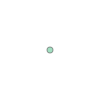

In [18]:
obs

In [19]:
%%time
roads_shp = fiona.open(basemap_dir)

CPU times: user 3.5 ms, sys: 7.68 ms, total: 11.2 ms
Wall time: 271 ms


In [20]:
roads_shp.crs

{'init': 'epsg:4326'}

In [ ]:
## https://gis.stackexchange.com/questions/80881/what-is-unit-of-shapely-length-attribute
# line1 = LineString([(15.799406, 40.636069), (15.810173,40.640246)])
# print str(line1.length) + " degrees"
# # 0.0115488362184 degrees

# # Geometry transform function based on pyproj.transform
# project_m = partial(
#     pyproj.transform,
#     pyproj.Proj(init='EPSG:4326'),
#     pyproj.Proj(init='EPSG:32633'))

# line2 = transform(project_m, line1)
# print str(line2.length) + " meters"
# # 1021.77585965 meters

In [832]:
roads_shp.schema

{'properties': OrderedDict([('osm_id', 'int:11'),
              ('name', 'str:48'),
              ('ref', 'str:16'),
              ('type', 'str:16'),
              ('oneway', 'int:1'),
              ('bridge', 'int:1'),
              ('maxspeed', 'int:3')]),
 'geometry': 'LineString'}

In [20]:
# Types of geometries
set([r['geometry']['type'] for r in list(roads_shp)])
# sf_shp: {'LineString'}

{'LineString'}

In [21]:
roads_shp[0]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('osm_id', 4311275),
              ('name', 'Bayshore Freeway'),
              ('ref', 'US 101'),
              ('type', 'motorway'),
              ('oneway', 1),
              ('bridge', 0),
              ('maxspeed', 65)]),
 'geometry': {'type': 'LineString',
  'coordinates': [(-122.4067318, 37.6552091),
   (-122.4066705, 37.6554806),
   (-122.4066, 37.6557348),
   (-122.4065183, 37.6560026),
   (-122.4064254, 37.6562575),
   (-122.4063177, 37.6565034),
   (-122.4061926, 37.6567579),
   (-122.4055559, 37.6579996),
   (-122.4053176, 37.6584642),
   (-122.4051888, 37.658704),
   (-122.405056, 37.6589448),
   (-122.4049166, 37.659174),
   (-122.4047675, 37.6593902),
   (-122.4046031, 37.6596144),
   (-122.4044278, 37.6598328),
   (-122.404206, 37.660081),
   (-122.4039932, 37.6603049),
   (-122.4037717, 37.6605162),
   (-122.4035097, 37.6607433),
   (-122.4032666, 37.6609362),
   (-122.4030265, 37.6611163),
   (-122.402762, 37.

In [21]:
%%time
# Wall time: 1.79 s
# Just preserving geometries for my purpose
road_geoms = [shape(shp['geometry']) for shp in roads_shp]

CPU times: user 1.46 s, sys: 75.9 ms, total: 1.54 s
Wall time: 1.66 s


In [22]:
%%time
# Wall time: 282 ms
# Create STR-tree
road_strtree = STRtree(road_geoms)

CPU times: user 250 ms, sys: 14.6 ms, total: 264 ms
Wall time: 262 ms


In [ ]:
# Run Particle Filter

In [241]:
my_particle_filter = particle_filter(road_strtree)

In [242]:
data = trace_df[['lat', 'long', 'lat_prev', 'long_prev', 'dist_from_prev_m', 'time_delta_sec']].copy()

In [239]:
%%time
results = my_particle_filter.fit(data)

On iteration 1, fit quality of MAX -0.68, MEAN -0.70, MEDIAN -0.68
[[  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75132504 -122.39487933]
 [  37.75134205 -122.39485713]
 [  37.75134205 -122.39485713]
 [ 

/Volumes/LaCie/anaconda/envs/map_matching_particle_filter/lib/python3.7/site-packages/ipykernel/__main__.py:154: RuntimeWarning: divide by zero encountered in log


[[  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.75200165 -122.3946008 ]
 [  37.7

KeyboardInterrupt: 

In [ ]:
#  IGNORE BELOW THIS POINT

In [ ]:
# https://stackoverflow.com/questions/4102520/how-to-transform-a-distance-from-degrees-to-metres
"""
@winwaed
The transformation between degrees and metres varies across the Earth's surface.
Assuming a spherical Earth, degrees latitude = distance * 360 / (2*PI * 6400000)
Note that longitude will vary according to the latitude:
Degrees longitude = distance *360 * / (2*PI* cos(latitude) )

The above is for the Earth's surface, and does not use the Mercator projection. 
If you wish to work with projected linear distance, then you will need to use the Mercator projection.
"""
# RADIUS_OF_EARTH_M = 6371000
# long, lat = list(obs.coords)[0]
# max_dist_deg = max_dist * 360 / (2 * np.pi * RADIUS_OF_EARTH_M)